In [6]:
# TODO: Add the spectrum estimation of the parameters of the graphs

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import sys
import os
sys.path.append('../')

# Graph imports
import src.graph as graph
import src.logit_estimator as estimator
import src.utils as utils
import src.model_selection as model_selection
import src.gic as gic
import src.param_estimator as pe
import src.graph as graph
import src.model_selection as ms

# usual imports import matplotlib.pyplot as plt
import math
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import gaussian_kde
import numpy as np
import pandas as pd
import seaborn as sns
import gc
import random
import networkx as nx

from IPython.display import display

from pyvis.network import Network

import pickle
import os

import math
from mpl_toolkits.axes_grid1 import make_axes_locatable



In [8]:
# ------------------------
# Functions
# ------------------------

def get_logit_graph(real_graph, d, n_iteration, warm_up, patience, dist_type='KL'):
   # Ensure real_graph is a NumPy array
   if isinstance(real_graph, nx.Graph):
       real_graph = nx.to_numpy_array(real_graph)
   
   # Estimation
   est = estimator.LogitRegEstimator(real_graph, d=d)
   features, labels = est.get_features_labels()
   result, params, pvalue = est.estimate_parameters(l1_wt=1, alpha=0, features=features, labels=labels)
   sigma = params[0]

   # Generation
   n = real_graph.shape[0]

   params_dict = {
      "n": n,
      "d": d,
      "sigma": sigma,
      "n_iteration": n_iteration,
      "warm_up": warm_up
   }

   graph_model = graph.GraphModel(n=n, d=d, sigma=sigma)
   graphs, spec, spectrum_diffs, best_iteration = graph_model.populate_edges_spectrum(
       warm_up=warm_up,
       max_iterations=n_iteration,
       patience=patience,  # You may want to adjust this value
       real_graph=real_graph
   )

   # Add early stopping condition
   if len(spectrum_diffs) > 10000 and all(abs(spectrum_diffs[-1] - sd) < 1e-6 for sd in spectrum_diffs[-10000:]):
       print("Early stopping: No significant improvement in the last 1000 iterations.")
       best_iteration = len(spectrum_diffs) - 10000

   # Use the best graph found
   best_graph = graphs[best_iteration]
   # Calculate GIC for the best graph
   best_graph_nx = nx.from_numpy_array(best_graph)
   gic_value = gic.GraphInformationCriterion(
       graph=nx.from_numpy_array(real_graph),
       log_graph=best_graph_nx,
       model='LG',
       dist_type=dist_type # KL or L1 or L2
   ).calculate_gic()
   
   gic_values = [gic_value]
   return best_graph, sigma, gic_values, spectrum_diffs, best_iteration, graphs

def clean_and_convert(param):
    cleaned_param = ''.join(c for c in param if c.isdigit() or c == '.' or c == '-')
    return float(cleaned_param)

def plot_graphs_in_matrix(sim_graphs_dict, result_dict, global_title, save_path=None):
    num_graphs = len(sim_graphs_dict)
    cols = min(4, num_graphs)  # Limit to 4 columns max
    rows = math.ceil(num_graphs / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5))
    if rows == 1 and cols == 1:
        axes = np.array([axes])
    axes = axes.flatten()

    for ax, (name, G) in zip(axes, sim_graphs_dict.items()):
        # Use force-directed layout for better distribution of nodes
        pos = nx.spring_layout(G, k=0.5, iterations=50)

        # Normalize node sizes and reduce
        degrees = dict(G.degree())
        max_degree = max(degrees.values())
        min_degree = min(degrees.values())
        node_sizes = [((degrees[node] - min_degree) / (max_degree - min_degree + 1e-6)) * 100 + 10 for node in G.nodes()]

        # Normalize node colors
        node_color = list(degrees.values())

        # Draw edges first
        edge_color = 'lightgray'
        alpha = 1
        width = 0.8
        if G.number_of_edges() > 1000:
            # For dense graphs, sample a subset of edges
            edges = list(G.edges())
            sampled_edges = np.random.choice(len(edges), size=1000, replace=False)
            edges = [edges[i] for i in sampled_edges]
            nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color=edge_color, alpha=alpha, width=width, ax=ax)
        else:
            nx.draw_networkx_edges(G, pos, edge_color=edge_color, alpha=alpha, width=width, ax=ax)

        # Draw nodes on top of edges
        scatter = nx.draw_networkx_nodes(G, pos, node_color=node_color, node_size=node_sizes, 
                                         cmap=plt.cm.viridis, ax=ax, alpha=0.8)

        # Set plot details
        if name != 'Real':
            ax.set_title(f'{name} Graph\nGIC: {result_dict[name]["GIC"]:.2f}', fontsize=10)
        else:
            ax.set_title(f'{name} Graph', fontsize=10)
        ax.axis('off')

        # Add a colorbar to show degree scale
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        cbar = plt.colorbar(scatter, cax=cax)
        cbar.set_label('Node Degree', fontsize=8)
        cbar.ax.tick_params(labelsize=6)

    # Hide unused axes
    for i in range(len(sim_graphs_dict), len(axes)):
        axes[i].set_visible(False)

    fig.suptitle(global_title, fontsize=16, fontweight='bold')
    plt.tight_layout()

    if save_path:
        fig.savefig(save_path, bbox_inches='tight', dpi=300)

    #plt.show()
    return fig

def plot_spectra_in_matrix(sim_graphs_dict, result_dict, global_title, bins=120, save_path=None):
    num_graphs = len(sim_graphs_dict)
    cols = min(4, num_graphs)  # Limit to 4 columns max
    rows = math.ceil(num_graphs / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5))
    if rows == 1 and cols == 1:
        axes = np.array([axes])
    axes = axes.flatten()

    for ax, (name, G) in zip(axes, sim_graphs_dict.items()):
        # Calculate the spectrum (eigenvalues) of the graph
        laplacian = nx.normalized_laplacian_matrix(G)
        eigenvalues = np.linalg.eigvals(laplacian.toarray())
        eigenvalues = np.real(eigenvalues)  # Take only the real part

        # Plot histogram of eigenvalues
        ax.hist(eigenvalues, bins=bins, density=True, alpha=0.7, color='skyblue')

        # Calculate and plot KDE
        kde = stats.gaussian_kde(eigenvalues)
        x_range = np.linspace(min(eigenvalues), max(eigenvalues), 200)
        ax.plot(x_range, kde(x_range), 'r-', lw=2)

        # Set plot details
        if name != 'Real':
            ax.set_title(f'{name} Graph Spectrum\nGIC: {result_dict[name]["GIC"]:.2f}', fontsize=15)
        else:
            ax.set_title(f'{name} Graph Spectrum', fontsize=15)
        ax.set_xlabel('Eigenvalue', fontsize=8)
        ax.set_ylabel('Density', fontsize=8)
        ax.tick_params(axis='both', which='major', labelsize=10)

        # Add text with graph properties
        props = f"Nodes: {G.number_of_nodes()}\nEdges: {G.number_of_edges()}"
        ax.text(0.95, 0.95, props, transform=ax.transAxes, fontsize=8,
                verticalalignment='top', horizontalalignment='right',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    # Hide unused axes
    for i in range(len(sim_graphs_dict), len(axes)):
        axes[i].set_visible(False)

    fig.suptitle(global_title, fontsize=20, fontweight='bold')
    plt.tight_layout()

    if save_path:
        fig.savefig(save_path, bbox_inches='tight', dpi=300)

    #plt.show()
    return fig


In [9]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Define a function to compute several features of a graph.
def compute_features(G):
    features = {}
    features['num_nodes'] = G.number_of_nodes()
    features['num_edges'] = G.number_of_edges()
    degrees = np.array(list(dict(G.degree()).values()))
    features['avg_degree'] = float(degrees.mean())
    features['density'] = nx.density(G)
    features['avg_clustering'] = nx.average_clustering(G)
    features['transitivity'] = nx.transitivity(G)
    # For average shortest path, if G is not connected, use the largest component.
    if nx.is_connected(G):
        features['avg_shortest_path'] = nx.average_shortest_path_length(G)
    else:
        largest_cc = max(nx.connected_components(G), key=len)
        subG = G.subgraph(largest_cc)
        features['avg_shortest_path'] = nx.average_shortest_path_length(subG)
    # Compute the spectral gap as the second-smallest eigenvalue of the Laplacian
    L = nx.laplacian_matrix(G).todense()
    eigenvalues = np.sort(np.linalg.eigvalsh(L))
    features['spectral_gap'] = float(eigenvalues[1]) if len(eigenvalues) > 1 else 0.0
    return features

In [10]:
np.random.seed(42)
datasets = f'../data/connectomes/'
#already_done = os.listdir('../images/imgs_connectomes/') 
#excluded = ['c.elegans.herm_pharynx_1.graphml']
#already_done = [os.path.splitext(file)[0] for file in already_done] + excluded

connectomes = sorted(os.listdir(datasets)) 
#connectomes = [connectome for connectome in connectomes if connectome not in already_done]
print(connectomes)
connectome_file = connectomes[0]

['c.elegans.herm_pharynx_1.graphml', 'c.elegans_neural.male_1.graphml', 'drosophila_medulla_1.graphml', 'kasthuri_graph_v4.graphml', 'mixed.species_brain_1.graphml', 'mouse_brain_1.graphml', 'mouse_retina_1.graphml', 'mouse_visual.cortex_1.graphml', 'mouse_visual.cortex_2.graphml', 'p.pacificus_neural.synaptic_1.graphml', 'p.pacificus_neural.synaptic_2.graphml', 'rattus.norvegicus_brain_1.graphml', 'rattus.norvegicus_brain_2.graphml', 'rattus.norvegicus_brain_3.graphml', 'rhesus_brain_1.graphml', 'rhesus_brain_2.graphml', 'rhesus_cerebral.cortex_1.graphml', 'rhesus_interareal.cortical.network_2.graphml']


In [43]:
# ------------------------
# Simulation settings
# ------------------------

# Number of simulations per model (can be increased if desired)
n_sim = 50

# Prepare a list to store the feature dictionaries of each simulation.
simulations = []

real_G = nx.read_graphml(os.path.join(datasets, connectome_file))
real_G = nx.from_numpy_array(nx.to_numpy_array(real_G))

# Compute and store the features of the real graph.
real_features = compute_features(real_G)
real_features['model'] = 'Real'
real_features['sim'] = 0  # simulation index (0 for the real graph)
simulations.append(real_features)

In [44]:
# ------------------------
# Compute some basic parameters based on the real graph.
# TODO: Improve this part of the code
# ------------------------
n = real_G.number_of_nodes()
avg_deg = float(np.mean(list(dict(real_G.degree()).values())))
p_er = avg_deg / (n - 1) if n > 1 else 0.0            # for ER
k_ws = max(2, int(round(avg_deg)))                    # for WS (k is the number of neighbors)
m_ba = max(1, int(round(avg_deg / 2)))                # for BA (m is the number of edges to attach)
k_reg = max(2, int(round(avg_deg)))                    # for K-regular (k is the degree)
theta = 0.5


In [45]:
# ------------------------
# Simulate graphs from different models and compute their features.
# ------------------------

# ER simulations
for i in range(n_sim):
    sim_graph = nx.erdos_renyi_graph(n=n, p=p_er)
    feat = compute_features(sim_graph)
    feat['model'] = 'ER'
    feat['sim'] = i
    simulations.append(feat)
 

In [46]:
# K-regular simulations
for i in range(n_sim):
    sim_graph = nx.random_regular_graph(d=k_reg, n=n)
    feat = compute_features(sim_graph)
    feat['model'] = 'K-regular'
    feat['sim'] = i
    simulations.append(feat)


In [47]:
# # GRG simulations
# for i in range(n_sim):
#     sim_graph = nx.geographic_threshold_graph(n=n, theta=theta)
#     feat = compute_features(sim_graph)
#     feat['model'] = 'GRG'
#     feat['sim'] = i
#     simulations.append(feat)


In [48]:
# WS simulations (Watts-Strogatz)
for i in range(n_sim):
    sim_graph = nx.watts_strogatz_graph(n=n, k=k_ws, p=p_er)
    feat = compute_features(sim_graph)
    feat['model'] = 'WS'
    feat['sim'] = i
    simulations.append(feat)
 

In [49]:
# BA simulations (Barabási-Albert)
for i in range(n_sim):
    sim_graph = nx.barabasi_albert_graph(n=n, m=m_ba)
    feat = compute_features(sim_graph)
    feat['model'] = 'BA'
    feat['sim'] = i
    simulations.append(feat)



In [50]:
# LG simulations (Logit Graph model).
N_ITERATION = 5000
WARM_UP = 5000
D = 0
PATIENCE = 5
DIST_TYPE = 'KL'

for i in range(n_sim):
    try:
        lg_graph_array, sigma, gic_values, spectrum_diffs, best_iteration, graphs = get_logit_graph(
            real_graph=real_G,
            d=D,
            n_iteration=N_ITERATION,
            warm_up=WARM_UP,
            patience=PATIENCE,
            dist_type=DIST_TYPE
        )
        lg_G = nx.from_numpy_array(lg_graph_array)
        feat = compute_features(lg_G)
        feat['model'] = 'LG'
        feat['sim'] = i
        simulations.append(feat)
    except Exception as e:
        print(f"Error in LG simulation {i}: {e}")



/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


                          Results: Logit
Model:              Logit            Method:           MLE        
Dependent Variable: y                Pseudo R-squared: 0.075      
Date:               2025-02-03 22:24 AIC:              16105.2225 
No. Observations:   38784            BIC:              16130.9198 
Df Model:           2                Log-Likelihood:   -8049.6    
Df Residuals:       38781            LL-Null:          -8700.5    
Converged:          1.0000           LLR p-value:      2.1522e-283
No. Iterations:     17.0000          Scale:            1.0000     
--------------------------------------------------------------------
           Coef.    Std.Err.      z       P>|z|     [0.025    0.975]
--------------------------------------------------------------------
const     -3.8168     0.0398   -95.8168   0.0000   -3.8948   -3.7387
x1         0.0109     0.0003    32.4207   0.0000    0.0103    0.0116
x2         0.0125     0.0006    22.6079   0.0000    0.0114    0.0136

iteratio

/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


                          Results: Logit
Model:              Logit            Method:           MLE        
Dependent Variable: y                Pseudo R-squared: 0.075      
Date:               2025-02-03 22:26 AIC:              16105.2225 
No. Observations:   38784            BIC:              16130.9198 
Df Model:           2                Log-Likelihood:   -8049.6    
Df Residuals:       38781            LL-Null:          -8700.5    
Converged:          1.0000           LLR p-value:      2.1522e-283
No. Iterations:     17.0000          Scale:            1.0000     
--------------------------------------------------------------------
           Coef.    Std.Err.      z       P>|z|     [0.025    0.975]
--------------------------------------------------------------------
const     -3.8168     0.0398   -95.8168   0.0000   -3.8948   -3.7387
x1         0.0109     0.0003    32.4207   0.0000    0.0103    0.0116
x2         0.0125     0.0006    22.6079   0.0000    0.0114    0.0136

iteratio

/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


                          Results: Logit
Model:              Logit            Method:           MLE        
Dependent Variable: y                Pseudo R-squared: 0.075      
Date:               2025-02-03 22:27 AIC:              16105.2225 
No. Observations:   38784            BIC:              16130.9198 
Df Model:           2                Log-Likelihood:   -8049.6    
Df Residuals:       38781            LL-Null:          -8700.5    
Converged:          1.0000           LLR p-value:      2.1522e-283
No. Iterations:     17.0000          Scale:            1.0000     
--------------------------------------------------------------------
           Coef.    Std.Err.      z       P>|z|     [0.025    0.975]
--------------------------------------------------------------------
const     -3.8168     0.0398   -95.8168   0.0000   -3.8948   -3.7387
x1         0.0109     0.0003    32.4207   0.0000    0.0103    0.0116
x2         0.0125     0.0006    22.6079   0.0000    0.0114    0.0136

iteratio

/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


                          Results: Logit
Model:              Logit            Method:           MLE        
Dependent Variable: y                Pseudo R-squared: 0.075      
Date:               2025-02-03 22:29 AIC:              16105.2225 
No. Observations:   38784            BIC:              16130.9198 
Df Model:           2                Log-Likelihood:   -8049.6    
Df Residuals:       38781            LL-Null:          -8700.5    
Converged:          1.0000           LLR p-value:      2.1522e-283
No. Iterations:     17.0000          Scale:            1.0000     
--------------------------------------------------------------------
           Coef.    Std.Err.      z       P>|z|     [0.025    0.975]
--------------------------------------------------------------------
const     -3.8168     0.0398   -95.8168   0.0000   -3.8948   -3.7387
x1         0.0109     0.0003    32.4207   0.0000    0.0103    0.0116
x2         0.0125     0.0006    22.6079   0.0000    0.0114    0.0136

iteratio

/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


                          Results: Logit
Model:              Logit            Method:           MLE        
Dependent Variable: y                Pseudo R-squared: 0.075      
Date:               2025-02-03 22:30 AIC:              16105.2225 
No. Observations:   38784            BIC:              16130.9198 
Df Model:           2                Log-Likelihood:   -8049.6    
Df Residuals:       38781            LL-Null:          -8700.5    
Converged:          1.0000           LLR p-value:      2.1522e-283
No. Iterations:     17.0000          Scale:            1.0000     
--------------------------------------------------------------------
           Coef.    Std.Err.      z       P>|z|     [0.025    0.975]
--------------------------------------------------------------------
const     -3.8168     0.0398   -95.8168   0.0000   -3.8948   -3.7387
x1         0.0109     0.0003    32.4207   0.0000    0.0103    0.0116
x2         0.0125     0.0006    22.6079   0.0000    0.0114    0.0136

iteratio

/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


                          Results: Logit
Model:              Logit            Method:           MLE        
Dependent Variable: y                Pseudo R-squared: 0.075      
Date:               2025-02-03 22:32 AIC:              16105.2225 
No. Observations:   38784            BIC:              16130.9198 
Df Model:           2                Log-Likelihood:   -8049.6    
Df Residuals:       38781            LL-Null:          -8700.5    
Converged:          1.0000           LLR p-value:      2.1522e-283
No. Iterations:     17.0000          Scale:            1.0000     
--------------------------------------------------------------------
           Coef.    Std.Err.      z       P>|z|     [0.025    0.975]
--------------------------------------------------------------------
const     -3.8168     0.0398   -95.8168   0.0000   -3.8948   -3.7387
x1         0.0109     0.0003    32.4207   0.0000    0.0103    0.0116
x2         0.0125     0.0006    22.6079   0.0000    0.0114    0.0136

iteratio

/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


                          Results: Logit
Model:              Logit            Method:           MLE        
Dependent Variable: y                Pseudo R-squared: 0.075      
Date:               2025-02-03 22:33 AIC:              16105.2225 
No. Observations:   38784            BIC:              16130.9198 
Df Model:           2                Log-Likelihood:   -8049.6    
Df Residuals:       38781            LL-Null:          -8700.5    
Converged:          1.0000           LLR p-value:      2.1522e-283
No. Iterations:     17.0000          Scale:            1.0000     
--------------------------------------------------------------------
           Coef.    Std.Err.      z       P>|z|     [0.025    0.975]
--------------------------------------------------------------------
const     -3.8168     0.0398   -95.8168   0.0000   -3.8948   -3.7387
x1         0.0109     0.0003    32.4207   0.0000    0.0103    0.0116
x2         0.0125     0.0006    22.6079   0.0000    0.0114    0.0136

iteratio

/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


                          Results: Logit
Model:              Logit            Method:           MLE        
Dependent Variable: y                Pseudo R-squared: 0.075      
Date:               2025-02-03 22:35 AIC:              16105.2225 
No. Observations:   38784            BIC:              16130.9198 
Df Model:           2                Log-Likelihood:   -8049.6    
Df Residuals:       38781            LL-Null:          -8700.5    
Converged:          1.0000           LLR p-value:      2.1522e-283
No. Iterations:     17.0000          Scale:            1.0000     
--------------------------------------------------------------------
           Coef.    Std.Err.      z       P>|z|     [0.025    0.975]
--------------------------------------------------------------------
const     -3.8168     0.0398   -95.8168   0.0000   -3.8948   -3.7387
x1         0.0109     0.0003    32.4207   0.0000    0.0103    0.0116
x2         0.0125     0.0006    22.6079   0.0000    0.0114    0.0136

iteratio

/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


                          Results: Logit
Model:              Logit            Method:           MLE        
Dependent Variable: y                Pseudo R-squared: 0.075      
Date:               2025-02-03 22:36 AIC:              16105.2225 
No. Observations:   38784            BIC:              16130.9198 
Df Model:           2                Log-Likelihood:   -8049.6    
Df Residuals:       38781            LL-Null:          -8700.5    
Converged:          1.0000           LLR p-value:      2.1522e-283
No. Iterations:     17.0000          Scale:            1.0000     
--------------------------------------------------------------------
           Coef.    Std.Err.      z       P>|z|     [0.025    0.975]
--------------------------------------------------------------------
const     -3.8168     0.0398   -95.8168   0.0000   -3.8948   -3.7387
x1         0.0109     0.0003    32.4207   0.0000    0.0103    0.0116
x2         0.0125     0.0006    22.6079   0.0000    0.0114    0.0136

iteratio

/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


                          Results: Logit
Model:              Logit            Method:           MLE        
Dependent Variable: y                Pseudo R-squared: 0.075      
Date:               2025-02-03 22:37 AIC:              16105.2225 
No. Observations:   38784            BIC:              16130.9198 
Df Model:           2                Log-Likelihood:   -8049.6    
Df Residuals:       38781            LL-Null:          -8700.5    
Converged:          1.0000           LLR p-value:      2.1522e-283
No. Iterations:     17.0000          Scale:            1.0000     
--------------------------------------------------------------------
           Coef.    Std.Err.      z       P>|z|     [0.025    0.975]
--------------------------------------------------------------------
const     -3.8168     0.0398   -95.8168   0.0000   -3.8948   -3.7387
x1         0.0109     0.0003    32.4207   0.0000    0.0103    0.0116
x2         0.0125     0.0006    22.6079   0.0000    0.0114    0.0136

iteratio

/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


                          Results: Logit
Model:              Logit            Method:           MLE        
Dependent Variable: y                Pseudo R-squared: 0.075      
Date:               2025-02-03 22:38 AIC:              16105.2225 
No. Observations:   38784            BIC:              16130.9198 
Df Model:           2                Log-Likelihood:   -8049.6    
Df Residuals:       38781            LL-Null:          -8700.5    
Converged:          1.0000           LLR p-value:      2.1522e-283
No. Iterations:     17.0000          Scale:            1.0000     
--------------------------------------------------------------------
           Coef.    Std.Err.      z       P>|z|     [0.025    0.975]
--------------------------------------------------------------------
const     -3.8168     0.0398   -95.8168   0.0000   -3.8948   -3.7387
x1         0.0109     0.0003    32.4207   0.0000    0.0103    0.0116
x2         0.0125     0.0006    22.6079   0.0000    0.0114    0.0136

iteratio

/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


                          Results: Logit
Model:              Logit            Method:           MLE        
Dependent Variable: y                Pseudo R-squared: 0.075      
Date:               2025-02-03 22:39 AIC:              16105.2225 
No. Observations:   38784            BIC:              16130.9198 
Df Model:           2                Log-Likelihood:   -8049.6    
Df Residuals:       38781            LL-Null:          -8700.5    
Converged:          1.0000           LLR p-value:      2.1522e-283
No. Iterations:     17.0000          Scale:            1.0000     
--------------------------------------------------------------------
           Coef.    Std.Err.      z       P>|z|     [0.025    0.975]
--------------------------------------------------------------------
const     -3.8168     0.0398   -95.8168   0.0000   -3.8948   -3.7387
x1         0.0109     0.0003    32.4207   0.0000    0.0103    0.0116
x2         0.0125     0.0006    22.6079   0.0000    0.0114    0.0136

iteratio

/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


                          Results: Logit
Model:              Logit            Method:           MLE        
Dependent Variable: y                Pseudo R-squared: 0.075      
Date:               2025-02-03 22:40 AIC:              16105.2225 
No. Observations:   38784            BIC:              16130.9198 
Df Model:           2                Log-Likelihood:   -8049.6    
Df Residuals:       38781            LL-Null:          -8700.5    
Converged:          1.0000           LLR p-value:      2.1522e-283
No. Iterations:     17.0000          Scale:            1.0000     
--------------------------------------------------------------------
           Coef.    Std.Err.      z       P>|z|     [0.025    0.975]
--------------------------------------------------------------------
const     -3.8168     0.0398   -95.8168   0.0000   -3.8948   -3.7387
x1         0.0109     0.0003    32.4207   0.0000    0.0103    0.0116
x2         0.0125     0.0006    22.6079   0.0000    0.0114    0.0136

iteratio

/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


                          Results: Logit
Model:              Logit            Method:           MLE        
Dependent Variable: y                Pseudo R-squared: 0.075      
Date:               2025-02-03 22:41 AIC:              16105.2225 
No. Observations:   38784            BIC:              16130.9198 
Df Model:           2                Log-Likelihood:   -8049.6    
Df Residuals:       38781            LL-Null:          -8700.5    
Converged:          1.0000           LLR p-value:      2.1522e-283
No. Iterations:     17.0000          Scale:            1.0000     
--------------------------------------------------------------------
           Coef.    Std.Err.      z       P>|z|     [0.025    0.975]
--------------------------------------------------------------------
const     -3.8168     0.0398   -95.8168   0.0000   -3.8948   -3.7387
x1         0.0109     0.0003    32.4207   0.0000    0.0103    0.0116
x2         0.0125     0.0006    22.6079   0.0000    0.0114    0.0136

iteratio

/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


                          Results: Logit
Model:              Logit            Method:           MLE        
Dependent Variable: y                Pseudo R-squared: 0.075      
Date:               2025-02-03 22:41 AIC:              16105.2225 
No. Observations:   38784            BIC:              16130.9198 
Df Model:           2                Log-Likelihood:   -8049.6    
Df Residuals:       38781            LL-Null:          -8700.5    
Converged:          1.0000           LLR p-value:      2.1522e-283
No. Iterations:     17.0000          Scale:            1.0000     
--------------------------------------------------------------------
           Coef.    Std.Err.      z       P>|z|     [0.025    0.975]
--------------------------------------------------------------------
const     -3.8168     0.0398   -95.8168   0.0000   -3.8948   -3.7387
x1         0.0109     0.0003    32.4207   0.0000    0.0103    0.0116
x2         0.0125     0.0006    22.6079   0.0000    0.0114    0.0136

iteratio

/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


                          Results: Logit
Model:              Logit            Method:           MLE        
Dependent Variable: y                Pseudo R-squared: 0.075      
Date:               2025-02-03 22:42 AIC:              16105.2225 
No. Observations:   38784            BIC:              16130.9198 
Df Model:           2                Log-Likelihood:   -8049.6    
Df Residuals:       38781            LL-Null:          -8700.5    
Converged:          1.0000           LLR p-value:      2.1522e-283
No. Iterations:     17.0000          Scale:            1.0000     
--------------------------------------------------------------------
           Coef.    Std.Err.      z       P>|z|     [0.025    0.975]
--------------------------------------------------------------------
const     -3.8168     0.0398   -95.8168   0.0000   -3.8948   -3.7387
x1         0.0109     0.0003    32.4207   0.0000    0.0103    0.0116
x2         0.0125     0.0006    22.6079   0.0000    0.0114    0.0136

iteratio

/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


                          Results: Logit
Model:              Logit            Method:           MLE        
Dependent Variable: y                Pseudo R-squared: 0.075      
Date:               2025-02-03 22:43 AIC:              16105.2225 
No. Observations:   38784            BIC:              16130.9198 
Df Model:           2                Log-Likelihood:   -8049.6    
Df Residuals:       38781            LL-Null:          -8700.5    
Converged:          1.0000           LLR p-value:      2.1522e-283
No. Iterations:     17.0000          Scale:            1.0000     
--------------------------------------------------------------------
           Coef.    Std.Err.      z       P>|z|     [0.025    0.975]
--------------------------------------------------------------------
const     -3.8168     0.0398   -95.8168   0.0000   -3.8948   -3.7387
x1         0.0109     0.0003    32.4207   0.0000    0.0103    0.0116
x2         0.0125     0.0006    22.6079   0.0000    0.0114    0.0136

iteratio

/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


                          Results: Logit
Model:              Logit            Method:           MLE        
Dependent Variable: y                Pseudo R-squared: 0.075      
Date:               2025-02-03 22:44 AIC:              16105.2225 
No. Observations:   38784            BIC:              16130.9198 
Df Model:           2                Log-Likelihood:   -8049.6    
Df Residuals:       38781            LL-Null:          -8700.5    
Converged:          1.0000           LLR p-value:      2.1522e-283
No. Iterations:     17.0000          Scale:            1.0000     
--------------------------------------------------------------------
           Coef.    Std.Err.      z       P>|z|     [0.025    0.975]
--------------------------------------------------------------------
const     -3.8168     0.0398   -95.8168   0.0000   -3.8948   -3.7387
x1         0.0109     0.0003    32.4207   0.0000    0.0103    0.0116
x2         0.0125     0.0006    22.6079   0.0000    0.0114    0.0136

iteratio

/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


                          Results: Logit
Model:              Logit            Method:           MLE        
Dependent Variable: y                Pseudo R-squared: 0.075      
Date:               2025-02-03 22:45 AIC:              16105.2225 
No. Observations:   38784            BIC:              16130.9198 
Df Model:           2                Log-Likelihood:   -8049.6    
Df Residuals:       38781            LL-Null:          -8700.5    
Converged:          1.0000           LLR p-value:      2.1522e-283
No. Iterations:     17.0000          Scale:            1.0000     
--------------------------------------------------------------------
           Coef.    Std.Err.      z       P>|z|     [0.025    0.975]
--------------------------------------------------------------------
const     -3.8168     0.0398   -95.8168   0.0000   -3.8948   -3.7387
x1         0.0109     0.0003    32.4207   0.0000    0.0103    0.0116
x2         0.0125     0.0006    22.6079   0.0000    0.0114    0.0136

iteratio

/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


                          Results: Logit
Model:              Logit            Method:           MLE        
Dependent Variable: y                Pseudo R-squared: 0.075      
Date:               2025-02-03 22:46 AIC:              16105.2225 
No. Observations:   38784            BIC:              16130.9198 
Df Model:           2                Log-Likelihood:   -8049.6    
Df Residuals:       38781            LL-Null:          -8700.5    
Converged:          1.0000           LLR p-value:      2.1522e-283
No. Iterations:     17.0000          Scale:            1.0000     
--------------------------------------------------------------------
           Coef.    Std.Err.      z       P>|z|     [0.025    0.975]
--------------------------------------------------------------------
const     -3.8168     0.0398   -95.8168   0.0000   -3.8948   -3.7387
x1         0.0109     0.0003    32.4207   0.0000    0.0103    0.0116
x2         0.0125     0.0006    22.6079   0.0000    0.0114    0.0136

iteratio

/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


                          Results: Logit
Model:              Logit            Method:           MLE        
Dependent Variable: y                Pseudo R-squared: 0.075      
Date:               2025-02-03 22:46 AIC:              16105.2225 
No. Observations:   38784            BIC:              16130.9198 
Df Model:           2                Log-Likelihood:   -8049.6    
Df Residuals:       38781            LL-Null:          -8700.5    
Converged:          1.0000           LLR p-value:      2.1522e-283
No. Iterations:     17.0000          Scale:            1.0000     
--------------------------------------------------------------------
           Coef.    Std.Err.      z       P>|z|     [0.025    0.975]
--------------------------------------------------------------------
const     -3.8168     0.0398   -95.8168   0.0000   -3.8948   -3.7387
x1         0.0109     0.0003    32.4207   0.0000    0.0103    0.0116
x2         0.0125     0.0006    22.6079   0.0000    0.0114    0.0136

iteratio

/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


                          Results: Logit
Model:              Logit            Method:           MLE        
Dependent Variable: y                Pseudo R-squared: 0.075      
Date:               2025-02-03 22:47 AIC:              16105.2225 
No. Observations:   38784            BIC:              16130.9198 
Df Model:           2                Log-Likelihood:   -8049.6    
Df Residuals:       38781            LL-Null:          -8700.5    
Converged:          1.0000           LLR p-value:      2.1522e-283
No. Iterations:     17.0000          Scale:            1.0000     
--------------------------------------------------------------------
           Coef.    Std.Err.      z       P>|z|     [0.025    0.975]
--------------------------------------------------------------------
const     -3.8168     0.0398   -95.8168   0.0000   -3.8948   -3.7387
x1         0.0109     0.0003    32.4207   0.0000    0.0103    0.0116
x2         0.0125     0.0006    22.6079   0.0000    0.0114    0.0136

iteratio

/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


                          Results: Logit
Model:              Logit            Method:           MLE        
Dependent Variable: y                Pseudo R-squared: 0.075      
Date:               2025-02-03 22:48 AIC:              16105.2225 
No. Observations:   38784            BIC:              16130.9198 
Df Model:           2                Log-Likelihood:   -8049.6    
Df Residuals:       38781            LL-Null:          -8700.5    
Converged:          1.0000           LLR p-value:      2.1522e-283
No. Iterations:     17.0000          Scale:            1.0000     
--------------------------------------------------------------------
           Coef.    Std.Err.      z       P>|z|     [0.025    0.975]
--------------------------------------------------------------------
const     -3.8168     0.0398   -95.8168   0.0000   -3.8948   -3.7387
x1         0.0109     0.0003    32.4207   0.0000    0.0103    0.0116
x2         0.0125     0.0006    22.6079   0.0000    0.0114    0.0136

iteratio

/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


                          Results: Logit
Model:              Logit            Method:           MLE        
Dependent Variable: y                Pseudo R-squared: 0.075      
Date:               2025-02-03 22:49 AIC:              16105.2225 
No. Observations:   38784            BIC:              16130.9198 
Df Model:           2                Log-Likelihood:   -8049.6    
Df Residuals:       38781            LL-Null:          -8700.5    
Converged:          1.0000           LLR p-value:      2.1522e-283
No. Iterations:     17.0000          Scale:            1.0000     
--------------------------------------------------------------------
           Coef.    Std.Err.      z       P>|z|     [0.025    0.975]
--------------------------------------------------------------------
const     -3.8168     0.0398   -95.8168   0.0000   -3.8948   -3.7387
x1         0.0109     0.0003    32.4207   0.0000    0.0103    0.0116
x2         0.0125     0.0006    22.6079   0.0000    0.0114    0.0136

iteratio

/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


                          Results: Logit
Model:              Logit            Method:           MLE        
Dependent Variable: y                Pseudo R-squared: 0.075      
Date:               2025-02-03 22:50 AIC:              16105.2225 
No. Observations:   38784            BIC:              16130.9198 
Df Model:           2                Log-Likelihood:   -8049.6    
Df Residuals:       38781            LL-Null:          -8700.5    
Converged:          1.0000           LLR p-value:      2.1522e-283
No. Iterations:     17.0000          Scale:            1.0000     
--------------------------------------------------------------------
           Coef.    Std.Err.      z       P>|z|     [0.025    0.975]
--------------------------------------------------------------------
const     -3.8168     0.0398   -95.8168   0.0000   -3.8948   -3.7387
x1         0.0109     0.0003    32.4207   0.0000    0.0103    0.0116
x2         0.0125     0.0006    22.6079   0.0000    0.0114    0.0136

iteratio

/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


                          Results: Logit
Model:              Logit            Method:           MLE        
Dependent Variable: y                Pseudo R-squared: 0.075      
Date:               2025-02-03 22:51 AIC:              16105.2225 
No. Observations:   38784            BIC:              16130.9198 
Df Model:           2                Log-Likelihood:   -8049.6    
Df Residuals:       38781            LL-Null:          -8700.5    
Converged:          1.0000           LLR p-value:      2.1522e-283
No. Iterations:     17.0000          Scale:            1.0000     
--------------------------------------------------------------------
           Coef.    Std.Err.      z       P>|z|     [0.025    0.975]
--------------------------------------------------------------------
const     -3.8168     0.0398   -95.8168   0.0000   -3.8948   -3.7387
x1         0.0109     0.0003    32.4207   0.0000    0.0103    0.0116
x2         0.0125     0.0006    22.6079   0.0000    0.0114    0.0136

iteratio

/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


                          Results: Logit
Model:              Logit            Method:           MLE        
Dependent Variable: y                Pseudo R-squared: 0.075      
Date:               2025-02-03 22:51 AIC:              16105.2225 
No. Observations:   38784            BIC:              16130.9198 
Df Model:           2                Log-Likelihood:   -8049.6    
Df Residuals:       38781            LL-Null:          -8700.5    
Converged:          1.0000           LLR p-value:      2.1522e-283
No. Iterations:     17.0000          Scale:            1.0000     
--------------------------------------------------------------------
           Coef.    Std.Err.      z       P>|z|     [0.025    0.975]
--------------------------------------------------------------------
const     -3.8168     0.0398   -95.8168   0.0000   -3.8948   -3.7387
x1         0.0109     0.0003    32.4207   0.0000    0.0103    0.0116
x2         0.0125     0.0006    22.6079   0.0000    0.0114    0.0136

iteratio

/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


                          Results: Logit
Model:              Logit            Method:           MLE        
Dependent Variable: y                Pseudo R-squared: 0.075      
Date:               2025-02-03 22:52 AIC:              16105.2225 
No. Observations:   38784            BIC:              16130.9198 
Df Model:           2                Log-Likelihood:   -8049.6    
Df Residuals:       38781            LL-Null:          -8700.5    
Converged:          1.0000           LLR p-value:      2.1522e-283
No. Iterations:     17.0000          Scale:            1.0000     
--------------------------------------------------------------------
           Coef.    Std.Err.      z       P>|z|     [0.025    0.975]
--------------------------------------------------------------------
const     -3.8168     0.0398   -95.8168   0.0000   -3.8948   -3.7387
x1         0.0109     0.0003    32.4207   0.0000    0.0103    0.0116
x2         0.0125     0.0006    22.6079   0.0000    0.0114    0.0136

iteratio

/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


                          Results: Logit
Model:              Logit            Method:           MLE        
Dependent Variable: y                Pseudo R-squared: 0.075      
Date:               2025-02-03 22:53 AIC:              16105.2225 
No. Observations:   38784            BIC:              16130.9198 
Df Model:           2                Log-Likelihood:   -8049.6    
Df Residuals:       38781            LL-Null:          -8700.5    
Converged:          1.0000           LLR p-value:      2.1522e-283
No. Iterations:     17.0000          Scale:            1.0000     
--------------------------------------------------------------------
           Coef.    Std.Err.      z       P>|z|     [0.025    0.975]
--------------------------------------------------------------------
const     -3.8168     0.0398   -95.8168   0.0000   -3.8948   -3.7387
x1         0.0109     0.0003    32.4207   0.0000    0.0103    0.0116
x2         0.0125     0.0006    22.6079   0.0000    0.0114    0.0136

iteratio

/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


                          Results: Logit
Model:              Logit            Method:           MLE        
Dependent Variable: y                Pseudo R-squared: 0.075      
Date:               2025-02-03 22:54 AIC:              16105.2225 
No. Observations:   38784            BIC:              16130.9198 
Df Model:           2                Log-Likelihood:   -8049.6    
Df Residuals:       38781            LL-Null:          -8700.5    
Converged:          1.0000           LLR p-value:      2.1522e-283
No. Iterations:     17.0000          Scale:            1.0000     
--------------------------------------------------------------------
           Coef.    Std.Err.      z       P>|z|     [0.025    0.975]
--------------------------------------------------------------------
const     -3.8168     0.0398   -95.8168   0.0000   -3.8948   -3.7387
x1         0.0109     0.0003    32.4207   0.0000    0.0103    0.0116
x2         0.0125     0.0006    22.6079   0.0000    0.0114    0.0136

iteratio

/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


                          Results: Logit
Model:              Logit            Method:           MLE        
Dependent Variable: y                Pseudo R-squared: 0.075      
Date:               2025-02-03 22:55 AIC:              16105.2225 
No. Observations:   38784            BIC:              16130.9198 
Df Model:           2                Log-Likelihood:   -8049.6    
Df Residuals:       38781            LL-Null:          -8700.5    
Converged:          1.0000           LLR p-value:      2.1522e-283
No. Iterations:     17.0000          Scale:            1.0000     
--------------------------------------------------------------------
           Coef.    Std.Err.      z       P>|z|     [0.025    0.975]
--------------------------------------------------------------------
const     -3.8168     0.0398   -95.8168   0.0000   -3.8948   -3.7387
x1         0.0109     0.0003    32.4207   0.0000    0.0103    0.0116
x2         0.0125     0.0006    22.6079   0.0000    0.0114    0.0136

iteratio

/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


                          Results: Logit
Model:              Logit            Method:           MLE        
Dependent Variable: y                Pseudo R-squared: 0.075      
Date:               2025-02-03 22:55 AIC:              16105.2225 
No. Observations:   38784            BIC:              16130.9198 
Df Model:           2                Log-Likelihood:   -8049.6    
Df Residuals:       38781            LL-Null:          -8700.5    
Converged:          1.0000           LLR p-value:      2.1522e-283
No. Iterations:     17.0000          Scale:            1.0000     
--------------------------------------------------------------------
           Coef.    Std.Err.      z       P>|z|     [0.025    0.975]
--------------------------------------------------------------------
const     -3.8168     0.0398   -95.8168   0.0000   -3.8948   -3.7387
x1         0.0109     0.0003    32.4207   0.0000    0.0103    0.0116
x2         0.0125     0.0006    22.6079   0.0000    0.0114    0.0136

iteratio

/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


                          Results: Logit
Model:              Logit            Method:           MLE        
Dependent Variable: y                Pseudo R-squared: 0.075      
Date:               2025-02-03 22:56 AIC:              16105.2225 
No. Observations:   38784            BIC:              16130.9198 
Df Model:           2                Log-Likelihood:   -8049.6    
Df Residuals:       38781            LL-Null:          -8700.5    
Converged:          1.0000           LLR p-value:      2.1522e-283
No. Iterations:     17.0000          Scale:            1.0000     
--------------------------------------------------------------------
           Coef.    Std.Err.      z       P>|z|     [0.025    0.975]
--------------------------------------------------------------------
const     -3.8168     0.0398   -95.8168   0.0000   -3.8948   -3.7387
x1         0.0109     0.0003    32.4207   0.0000    0.0103    0.0116
x2         0.0125     0.0006    22.6079   0.0000    0.0114    0.0136

iteratio

/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


                          Results: Logit
Model:              Logit            Method:           MLE        
Dependent Variable: y                Pseudo R-squared: 0.075      
Date:               2025-02-03 22:57 AIC:              16105.2225 
No. Observations:   38784            BIC:              16130.9198 
Df Model:           2                Log-Likelihood:   -8049.6    
Df Residuals:       38781            LL-Null:          -8700.5    
Converged:          1.0000           LLR p-value:      2.1522e-283
No. Iterations:     17.0000          Scale:            1.0000     
--------------------------------------------------------------------
           Coef.    Std.Err.      z       P>|z|     [0.025    0.975]
--------------------------------------------------------------------
const     -3.8168     0.0398   -95.8168   0.0000   -3.8948   -3.7387
x1         0.0109     0.0003    32.4207   0.0000    0.0103    0.0116
x2         0.0125     0.0006    22.6079   0.0000    0.0114    0.0136

iteratio

/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


                          Results: Logit
Model:              Logit            Method:           MLE        
Dependent Variable: y                Pseudo R-squared: 0.075      
Date:               2025-02-03 22:58 AIC:              16105.2225 
No. Observations:   38784            BIC:              16130.9198 
Df Model:           2                Log-Likelihood:   -8049.6    
Df Residuals:       38781            LL-Null:          -8700.5    
Converged:          1.0000           LLR p-value:      2.1522e-283
No. Iterations:     17.0000          Scale:            1.0000     
--------------------------------------------------------------------
           Coef.    Std.Err.      z       P>|z|     [0.025    0.975]
--------------------------------------------------------------------
const     -3.8168     0.0398   -95.8168   0.0000   -3.8948   -3.7387
x1         0.0109     0.0003    32.4207   0.0000    0.0103    0.0116
x2         0.0125     0.0006    22.6079   0.0000    0.0114    0.0136

iteratio

/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


                          Results: Logit
Model:              Logit            Method:           MLE        
Dependent Variable: y                Pseudo R-squared: 0.075      
Date:               2025-02-03 22:58 AIC:              16105.2225 
No. Observations:   38784            BIC:              16130.9198 
Df Model:           2                Log-Likelihood:   -8049.6    
Df Residuals:       38781            LL-Null:          -8700.5    
Converged:          1.0000           LLR p-value:      2.1522e-283
No. Iterations:     17.0000          Scale:            1.0000     
--------------------------------------------------------------------
           Coef.    Std.Err.      z       P>|z|     [0.025    0.975]
--------------------------------------------------------------------
const     -3.8168     0.0398   -95.8168   0.0000   -3.8948   -3.7387
x1         0.0109     0.0003    32.4207   0.0000    0.0103    0.0116
x2         0.0125     0.0006    22.6079   0.0000    0.0114    0.0136

iteratio

/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


                          Results: Logit
Model:              Logit            Method:           MLE        
Dependent Variable: y                Pseudo R-squared: 0.075      
Date:               2025-02-03 22:59 AIC:              16105.2225 
No. Observations:   38784            BIC:              16130.9198 
Df Model:           2                Log-Likelihood:   -8049.6    
Df Residuals:       38781            LL-Null:          -8700.5    
Converged:          1.0000           LLR p-value:      2.1522e-283
No. Iterations:     17.0000          Scale:            1.0000     
--------------------------------------------------------------------
           Coef.    Std.Err.      z       P>|z|     [0.025    0.975]
--------------------------------------------------------------------
const     -3.8168     0.0398   -95.8168   0.0000   -3.8948   -3.7387
x1         0.0109     0.0003    32.4207   0.0000    0.0103    0.0116
x2         0.0125     0.0006    22.6079   0.0000    0.0114    0.0136

iteratio

/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


                          Results: Logit
Model:              Logit            Method:           MLE        
Dependent Variable: y                Pseudo R-squared: 0.075      
Date:               2025-02-03 23:00 AIC:              16105.2225 
No. Observations:   38784            BIC:              16130.9198 
Df Model:           2                Log-Likelihood:   -8049.6    
Df Residuals:       38781            LL-Null:          -8700.5    
Converged:          1.0000           LLR p-value:      2.1522e-283
No. Iterations:     17.0000          Scale:            1.0000     
--------------------------------------------------------------------
           Coef.    Std.Err.      z       P>|z|     [0.025    0.975]
--------------------------------------------------------------------
const     -3.8168     0.0398   -95.8168   0.0000   -3.8948   -3.7387
x1         0.0109     0.0003    32.4207   0.0000    0.0103    0.0116
x2         0.0125     0.0006    22.6079   0.0000    0.0114    0.0136

iteratio

/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


                          Results: Logit
Model:              Logit            Method:           MLE        
Dependent Variable: y                Pseudo R-squared: 0.075      
Date:               2025-02-03 23:01 AIC:              16105.2225 
No. Observations:   38784            BIC:              16130.9198 
Df Model:           2                Log-Likelihood:   -8049.6    
Df Residuals:       38781            LL-Null:          -8700.5    
Converged:          1.0000           LLR p-value:      2.1522e-283
No. Iterations:     17.0000          Scale:            1.0000     
--------------------------------------------------------------------
           Coef.    Std.Err.      z       P>|z|     [0.025    0.975]
--------------------------------------------------------------------
const     -3.8168     0.0398   -95.8168   0.0000   -3.8948   -3.7387
x1         0.0109     0.0003    32.4207   0.0000    0.0103    0.0116
x2         0.0125     0.0006    22.6079   0.0000    0.0114    0.0136

iteratio

/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


                          Results: Logit
Model:              Logit            Method:           MLE        
Dependent Variable: y                Pseudo R-squared: 0.075      
Date:               2025-02-03 23:02 AIC:              16105.2225 
No. Observations:   38784            BIC:              16130.9198 
Df Model:           2                Log-Likelihood:   -8049.6    
Df Residuals:       38781            LL-Null:          -8700.5    
Converged:          1.0000           LLR p-value:      2.1522e-283
No. Iterations:     17.0000          Scale:            1.0000     
--------------------------------------------------------------------
           Coef.    Std.Err.      z       P>|z|     [0.025    0.975]
--------------------------------------------------------------------
const     -3.8168     0.0398   -95.8168   0.0000   -3.8948   -3.7387
x1         0.0109     0.0003    32.4207   0.0000    0.0103    0.0116
x2         0.0125     0.0006    22.6079   0.0000    0.0114    0.0136

iteratio

/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


                          Results: Logit
Model:              Logit            Method:           MLE        
Dependent Variable: y                Pseudo R-squared: 0.075      
Date:               2025-02-03 23:03 AIC:              16105.2225 
No. Observations:   38784            BIC:              16130.9198 
Df Model:           2                Log-Likelihood:   -8049.6    
Df Residuals:       38781            LL-Null:          -8700.5    
Converged:          1.0000           LLR p-value:      2.1522e-283
No. Iterations:     17.0000          Scale:            1.0000     
--------------------------------------------------------------------
           Coef.    Std.Err.      z       P>|z|     [0.025    0.975]
--------------------------------------------------------------------
const     -3.8168     0.0398   -95.8168   0.0000   -3.8948   -3.7387
x1         0.0109     0.0003    32.4207   0.0000    0.0103    0.0116
x2         0.0125     0.0006    22.6079   0.0000    0.0114    0.0136

iteratio

/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


                          Results: Logit
Model:              Logit            Method:           MLE        
Dependent Variable: y                Pseudo R-squared: 0.075      
Date:               2025-02-03 23:03 AIC:              16105.2225 
No. Observations:   38784            BIC:              16130.9198 
Df Model:           2                Log-Likelihood:   -8049.6    
Df Residuals:       38781            LL-Null:          -8700.5    
Converged:          1.0000           LLR p-value:      2.1522e-283
No. Iterations:     17.0000          Scale:            1.0000     
--------------------------------------------------------------------
           Coef.    Std.Err.      z       P>|z|     [0.025    0.975]
--------------------------------------------------------------------
const     -3.8168     0.0398   -95.8168   0.0000   -3.8948   -3.7387
x1         0.0109     0.0003    32.4207   0.0000    0.0103    0.0116
x2         0.0125     0.0006    22.6079   0.0000    0.0114    0.0136

iteratio

/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


                          Results: Logit
Model:              Logit            Method:           MLE        
Dependent Variable: y                Pseudo R-squared: 0.075      
Date:               2025-02-03 23:04 AIC:              16105.2225 
No. Observations:   38784            BIC:              16130.9198 
Df Model:           2                Log-Likelihood:   -8049.6    
Df Residuals:       38781            LL-Null:          -8700.5    
Converged:          1.0000           LLR p-value:      2.1522e-283
No. Iterations:     17.0000          Scale:            1.0000     
--------------------------------------------------------------------
           Coef.    Std.Err.      z       P>|z|     [0.025    0.975]
--------------------------------------------------------------------
const     -3.8168     0.0398   -95.8168   0.0000   -3.8948   -3.7387
x1         0.0109     0.0003    32.4207   0.0000    0.0103    0.0116
x2         0.0125     0.0006    22.6079   0.0000    0.0114    0.0136

iteratio

/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


                          Results: Logit
Model:              Logit            Method:           MLE        
Dependent Variable: y                Pseudo R-squared: 0.075      
Date:               2025-02-03 23:05 AIC:              16105.2225 
No. Observations:   38784            BIC:              16130.9198 
Df Model:           2                Log-Likelihood:   -8049.6    
Df Residuals:       38781            LL-Null:          -8700.5    
Converged:          1.0000           LLR p-value:      2.1522e-283
No. Iterations:     17.0000          Scale:            1.0000     
--------------------------------------------------------------------
           Coef.    Std.Err.      z       P>|z|     [0.025    0.975]
--------------------------------------------------------------------
const     -3.8168     0.0398   -95.8168   0.0000   -3.8948   -3.7387
x1         0.0109     0.0003    32.4207   0.0000    0.0103    0.0116
x2         0.0125     0.0006    22.6079   0.0000    0.0114    0.0136

iteratio

/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


                          Results: Logit
Model:              Logit            Method:           MLE        
Dependent Variable: y                Pseudo R-squared: 0.075      
Date:               2025-02-03 23:05 AIC:              16105.2225 
No. Observations:   38784            BIC:              16130.9198 
Df Model:           2                Log-Likelihood:   -8049.6    
Df Residuals:       38781            LL-Null:          -8700.5    
Converged:          1.0000           LLR p-value:      2.1522e-283
No. Iterations:     17.0000          Scale:            1.0000     
--------------------------------------------------------------------
           Coef.    Std.Err.      z       P>|z|     [0.025    0.975]
--------------------------------------------------------------------
const     -3.8168     0.0398   -95.8168   0.0000   -3.8948   -3.7387
x1         0.0109     0.0003    32.4207   0.0000    0.0103    0.0116
x2         0.0125     0.0006    22.6079   0.0000    0.0114    0.0136

iteratio

/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


                          Results: Logit
Model:              Logit            Method:           MLE        
Dependent Variable: y                Pseudo R-squared: 0.075      
Date:               2025-02-03 23:06 AIC:              16105.2225 
No. Observations:   38784            BIC:              16130.9198 
Df Model:           2                Log-Likelihood:   -8049.6    
Df Residuals:       38781            LL-Null:          -8700.5    
Converged:          1.0000           LLR p-value:      2.1522e-283
No. Iterations:     17.0000          Scale:            1.0000     
--------------------------------------------------------------------
           Coef.    Std.Err.      z       P>|z|     [0.025    0.975]
--------------------------------------------------------------------
const     -3.8168     0.0398   -95.8168   0.0000   -3.8948   -3.7387
x1         0.0109     0.0003    32.4207   0.0000    0.0103    0.0116
x2         0.0125     0.0006    22.6079   0.0000    0.0114    0.0136

iteratio

/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


                          Results: Logit
Model:              Logit            Method:           MLE        
Dependent Variable: y                Pseudo R-squared: 0.075      
Date:               2025-02-03 23:07 AIC:              16105.2225 
No. Observations:   38784            BIC:              16130.9198 
Df Model:           2                Log-Likelihood:   -8049.6    
Df Residuals:       38781            LL-Null:          -8700.5    
Converged:          1.0000           LLR p-value:      2.1522e-283
No. Iterations:     17.0000          Scale:            1.0000     
--------------------------------------------------------------------
           Coef.    Std.Err.      z       P>|z|     [0.025    0.975]
--------------------------------------------------------------------
const     -3.8168     0.0398   -95.8168   0.0000   -3.8948   -3.7387
x1         0.0109     0.0003    32.4207   0.0000    0.0103    0.0116
x2         0.0125     0.0006    22.6079   0.0000    0.0114    0.0136

iteratio

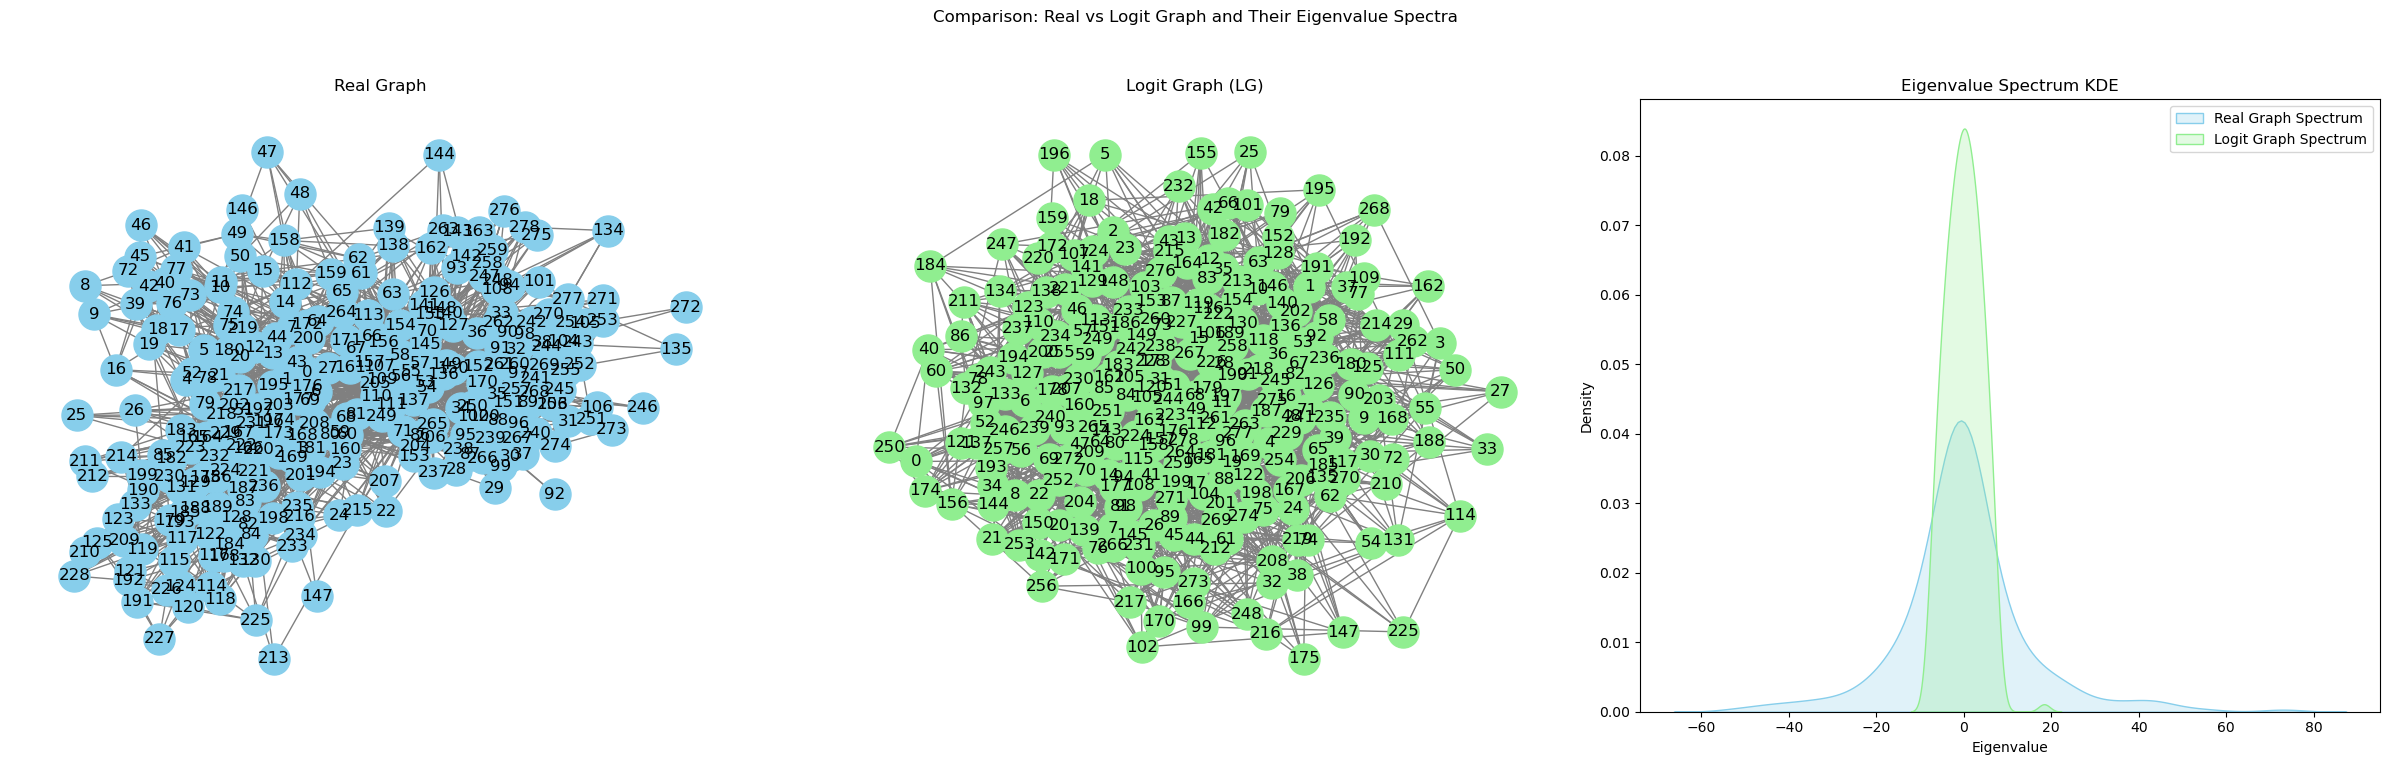

In [16]:
# Plot a visualization to compare the real graph and a logit graph, and add their eigenvalue spectrum with a KDE estimation.
fig, axes = plt.subplots(1, 3, figsize=(24, 8))

# Plot the real graph in the left subplot
pos_real = nx.spring_layout(real_G)
nx.draw(real_G, pos_real, ax=axes[0],
        node_color='skyblue',
        edge_color='gray',
        with_labels=True,
        node_size=500)
axes[0].set_title('Real Graph')

# Plot the logit graph (LG) in the middle subplot
pos_lg = nx.spring_layout(lg_G)
nx.draw(lg_G, pos_lg, ax=axes[1],
        node_color='lightgreen',
        edge_color='gray',
        with_labels=True,
        node_size=500)
axes[1].set_title('Logit Graph (LG)')

# Plot the spectrum with KDE estimation in the right subplot.
# Compute the eigenvalue spectrum for both graphs using the adjacency matrix.
real_eig = nx.adjacency_spectrum(real_G).real
lg_eig = nx.adjacency_spectrum(lg_G).real

# Plot the kernel density estimate for each spectrum.
sns.kdeplot(real_eig, ax=axes[2], label='Real Graph Spectrum', fill=True, color='skyblue')
sns.kdeplot(lg_eig, ax=axes[2], label='Logit Graph Spectrum', fill=True, color='lightgreen')
axes[2].set_title('Eigenvalue Spectrum KDE')
axes[2].set_xlabel('Eigenvalue')
axes[2].set_ylabel('Density')
axes[2].legend()

plt.suptitle('Comparison: Real vs Logit Graph and Their Eigenvalue Spectra')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [17]:
# Create a Pandas DataFrame from the simulation list.
df_features = pd.DataFrame(simulations)
import datetime
filename = f'features_pca_analysis_{connectome_file}_{hash(datetime.now().strftime("%Y%m%d_%H%M%S"))}.parquet'
print(filename)
df_features.to_parquet(filename)

df_features

Feature table:


,num_nodes,num_edges,avg_degree,density,avg_clustering,transitivity,avg_shortest_path,spectral_gap,model,sim
0,279,2290,16.415771,0.059050,0.337134,0.213481,2.435626,2.978042,Real,0
1,279,2304,16.516129,0.059411,0.062276,0.062470,2.294423,6.060019,ER,0
2,279,2244,16.086022,0.057863,0.063305,0.061718,2.316934,5.444321,ER,1
3,279,2356,16.888889,0.060751,0.059493,0.059497,2.273201,6.354291,ER,2
4,279,2300,16.487455,0.059307,0.059023,0.059396,2.296305,5.459334,ER,3
...,...,...,...,...,...,...,...,...,...,...
56,279,2344,16.802867,0.060442,0.066896,0.065688,2.283489,4.464059,LG,5
57,279,2507,17.971326,0.064645,0.069159,0.068117,2.229494,5.585099,LG,6
58,279,2456,17.605735,0.063330,0.069253,0.069766,2.252598,4.562915,LG,7
59,279,2304,16.516129,0.059411,0.061000,0.061739,2.297749,4.440350,LG,8


In [11]:
# Add a timestamp to the file name.
hash = ''
filename = f'features_pca_analysis_{connectome_file}_{hash}.parquet'
filename = '/Users/maruanottoni/home/master/research/logit-graph/notebooks/features_pca_analysis_c.elegans.herm_pharynx_1.graphml_5732953374981879580.parquet'
df_features =  pd.read_parquet(filename)

In [12]:
# ------------------------
# Dimensionality reduction (using PCA and t-SNE)
# ------------------------

# We will use the following numeric feature columns.
feature_columns = ['num_edges', 'avg_degree', 'density', 'avg_clustering', 'transitivity', 'avg_shortest_path', 'spectral_gap']
X = df_features[feature_columns].values

# Apply PCA to reduce the dimensionality to 2 components.
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
df_features['PC1'] = X_pca[:, 0]
df_features['PC2'] = X_pca[:, 1]


In [13]:
# # Also apply t-SNE for comparison.
# tsne = TSNE(n_components=2, random_state=42)
# X_tsne = tsne.fit_transform(X)
# df_features['tSNE1'] = X_tsne[:, 0]
# df_features['tSNE2'] = X_tsne[:, 1]



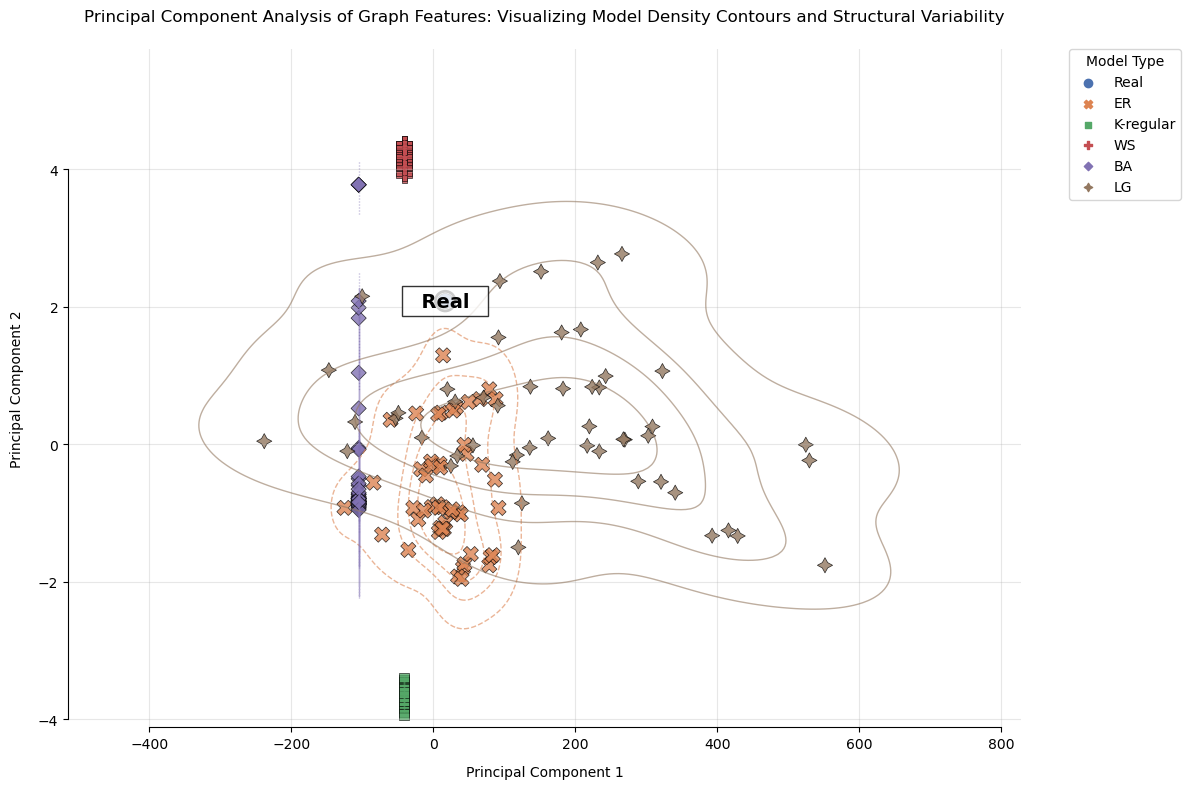

In [14]:
# ------------------------
# Plot the results
# ------------------------

# PCA plot with density contours
plt.figure(figsize=(12, 8))
ax = plt.gca()

# Create a color palette mapping
palette = sns.color_palette("deep")
model_types = df_features['model'].unique()
palette = {model: palette[i] for i, model in enumerate(model_types)}

# Plot density contours for each model family
# (Removed label from the KDE plots so that legend symbols come solely from the scatter plot)
for model in model_types:
    if model == 'Real':  # Skip density for real graph
        continue
    subset = df_features[df_features['model'] == model]
    sns.kdeplot(
        x=subset['PC1'], y=subset['PC2'],
        color=palette[model],
        levels=5, linewidths=1, alpha=0.6,
        linestyles='--' if model == 'ER' else '-',
        ax=ax
    )

# Scatter plot with enhanced aesthetics (ensuring legend entries display marker symbols)
scatter = sns.scatterplot(
    data=df_features, x='PC1', y='PC2',
    hue='model', style='model',
    s=120, edgecolor='black', linewidth=0.5,
    palette=palette, alpha=0.8, ax=ax,
    legend='full'
)

# Highlight and annotate the real graph
for _, row in df_features.iterrows():
    if row['model'] == 'Real':
        plt.scatter(row['PC1'], row['PC2'], s=200, facecolors='none', edgecolors='black', linewidth=2)
        plt.text(row['PC1'], row['PC2'], '  Real  ', fontsize=14, weight='bold', 
                 color='black', ha='center', va='center', 
                 bbox=dict(facecolor='white', alpha=0.8, edgecolor='black'))

# Add plot decorations
plt.title('Principal Component Analysis of Graph Features: Visualizing Model Density Contours and Structural Variability', pad=20)
plt.xlabel('Principal Component 1', labelpad=10)
plt.ylabel('Principal Component 2', labelpad=10)
plt.grid(True, alpha=0.3)
sns.despine(trim=True)

# Create combined legend based solely on scatter plot entries
handles, labels = ax.get_legend_handles_labels()
plt.legend(
    handles, labels,
    title='Model Type', bbox_to_anchor=(1.05, 1),
    loc='upper left', borderaxespad=0
)

plt.tight_layout()
plt.savefig(f'pca_analysis_{connectome_file}_{hash}.png')
plt.show()

In [15]:
8132810


8132810